In [7]:
import os, shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.transforms.v2.functional as F_v2
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
from Utils.dataset import PreloadedDataset
import matplotlib.pyplot as plt
from tqdm import tqdm

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from Methods.iGPA.model import iGPA
from Methods.BYOL.model import BYOL
from Methods.AE.model import AE
from Methods.MAE.model import MAE
from Methods.GPAViT.model import GPAViT
from Methods.GPAMAE.model import GPAMAE
from Methods.VAE.model import VAE
from Methods.Supervised.model import Supervised


from Utils.train import train
from Utils.evals import linear_probing
from Utils.functional import get_optimiser, aug_interact, aug_transform

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True
device

device(type='cuda')

In [13]:
root = '../Datasets/'
dataset = datasets.MNIST(root=root, train=True, transform=transforms.ToTensor(), download=True)
t_dataset = datasets.MNIST(root=root, train=False, transform=transforms.ToTensor(), download=True)

VAL_RATIO = 0.2
n_val = int(len(dataset) * VAL_RATIO)
n_train = len(dataset) - n_val
train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n_val])

# train_transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Pad(2),
#     # transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
#     # transforms.Normalize((0.1307,), (0.3081,)),
#     # SigmoidTransform(),
#     # TanhTransform(),
# ])

# val_transform = transforms.Compose([
#     transforms.ToTensor(),
#     # transforms.Pad(2),
#     # transforms.Normalize((0.1307,), (0.3081,)),
#     # SigmoidTransform(),
#     # TanhTransform()
# ])
train_transform, val_transform = None, None

augmentation = transforms.Compose([
    transforms.RandomCrop(20),
    transforms.Resize(28, interpolation=transforms.InterpolationMode.NEAREST),
    # transforms.RandomAffine(degrees=180, translate=(0.28, 0.28), scale=(0.75, 1.25), shear=25),
    transforms.RandomAffine(degrees=30, translate=(0.1, 0.1), scale=(0.75, 1.25), shear=25),
    # transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
])

train_set = PreloadedDataset.from_dataset(train_set, train_transform, device)
val_set = PreloadedDataset.from_dataset(val_set, val_transform, device)
test_set = PreloadedDataset.from_dataset(t_dataset, val_transform, device)

In [15]:
train_set[0][0].shape

torch.Size([1, 28, 28])

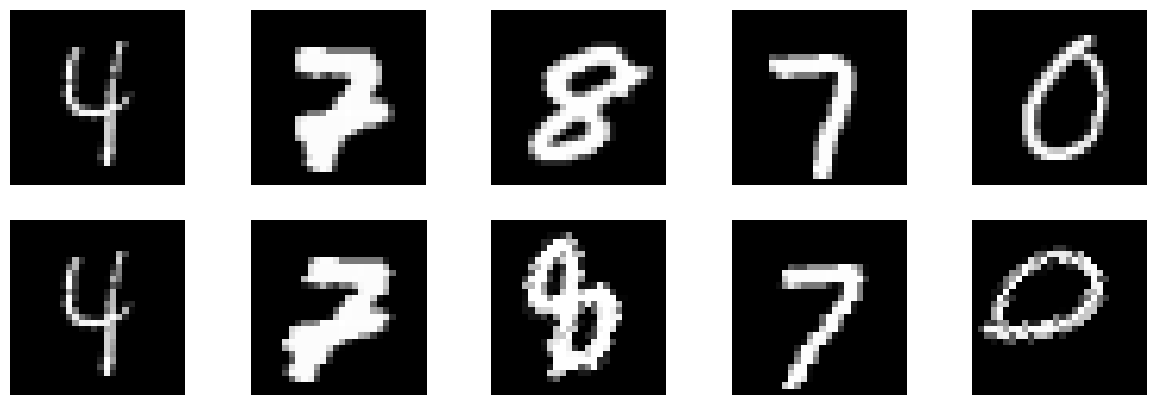

Max value: tensor(1., device='cuda:0')
Min value: tensor(0., device='cuda:0')


In [ ]:
# Show example images
# fig, axes = plt.subplots(1, 10, figsize=(15,5))
# for i, ax in enumerate(axes):
#     img, label = train_set[i]
#     angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
#     translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
#     scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
#     shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
#     img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
#     ax.imshow(img.squeeze().cpu(), cmap='gray')
#     ax.set_title(f"Label: {label}")
#     ax.axis('off')
# plt.show()

# show before and after on each row
fig, axes = plt.subplots(2, 5, figsize=(15,5))
for i, ax in enumerate(axes[0]):
    img, label = train_set[i+20]
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axes[1]):
    img, label = train_set[i+20]
    angle = torch.rand(1).item() * 360 - 180 if torch.rand(1).item() > 0.75 else 0
    translate_x = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    translate_y = torch.randint(-8, 9, (1,)).item() if torch.rand(1).item() > 0.75 else 0
    scale = torch.rand(1).item() * 0.5 + 0.75 if torch.rand(1).item() > 0.75 else 1.0
    shear = torch.rand(1).item() * 50 - 25 if torch.rand(1).item() > 0.75 else 0
    img = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    ax.imshow(img.squeeze().cpu(), cmap='gray')
    ax.axis('off')
plt.show()



# print max and min values
print('Max value:', train_set.transformed_images.max())
print('Min value:', train_set.transformed_images.min())

In [6]:
cfgs = [
    {
        'name': 'AE',
        'model': AE,
        'save': False,
    },
]

for cfg_args in cfgs:

    experiment='kwarg_test'
    trial = cfg_args['name']
    Model = cfg_args['model']
    backbone = 'mnist_cnn'
    log=True

    # Logging Initialisation
    writer=None
    enc_log_dir = f'Examples/MNIST/out/logs/{experiment}/Encoder/{trial}/'
    run_no = 0
    while os.path.exists(enc_log_dir + f'/run_{run_no}'):
        run_no += 1
    writer = SummaryWriter(enc_log_dir + f'/run_{run_no}')
    # remove reduction if exists
    if os.path.exists(enc_log_dir + '/reduction.csv'):
        os.remove(enc_log_dir + '/reduction.csv')

    # Save Initialisation
    save_dir = None
    if cfg_args['save']:
        save_dir = f'Examples/MNIST/out/models/{experiment}/{trial}/run_{run_no}.pth'

    if Model == VAE:
        model = Model(1, 256).to(device)
    elif Model == AE or Model == BYOL or Model == MAE:
        model = Model(1).to(device)
    else:
        model = Model(1, 5).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:

        train_set.transform = None
        
        train(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            dataset='mnist',
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
        
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # # linear probing
    # for n in [1, 10, 100, 1000]:
    #     dest = f'Examples/MNIST/out/logs/{experiment}/Classifier-n{n}/{experiment_name}/'
    #     run_no = 1
    #     while os.path.exists(dest + f'classifier/run_{run_no}'):
    #         run_no += 1
    #     writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    #     linear_probing(model, 'mnist', root, n, writer, flatten=False, test=True)

{'has_teacher': False, 'aug_mode': 'none'}
has_teacher: False, aug_mode: none, augment: None


KeyboardInterrupt: 

In [4]:
train_set[0]

NameError: name 'train_set' is not defined

In [5]:
model = iGPA(1, 5).to(device)
name = 'GPA'
experiment = 'mnist'
save_dir = f'Examples/MNIST/out/models/{experiment}/{name}.pth'
sd = torch.load(save_dir)
model.load_state_dict(sd)

experiment = 'probing'
experiment_name = 'GPA-L2'

# linear probing
for n in [1, 10, 100, 1000]:
    dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
    run_no = 1
    while os.path.exists(dest + f'classifier/run_{run_no}'):
        run_no += 1
    writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    linear_probing(model, 'mnist', root, n, writer, flatten=False, test=True)

Test accuracy: 0.6496999859809875
Best validation accuracy: 0.6551000475883484


Test accuracy: 0.886199951171875
Best validation accuracy: 0.878300130367279


Test accuracy: 0.9750999212265015
Best validation accuracy: 0.9715000987052917


Test accuracy: 0.9834999442100525
Best validation accuracy: 0.9843000769615173


In [46]:
x = torch.randn(1, 20)
layer = nn.LayerNorm(x.shape[1], elementwise_affine=False)
norm1 = layer(x)
norm2 = F.normalize(x)
torch.allclose(norm1, norm2)
norm1.norm(), norm2.norm()

(tensor(4.4721), tensor(1.))

In [8]:
# save model
save_dir = f'Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
torch.save(model.state_dict(), save_dir)


In [ ]:

sd = torch.load('Examples/MNIST/out/models/mae/mae.pth')
model.load_state_dict(sd)
# # linear probing
# for n in [1, 10, 100, 1000]:
#     dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
#     if log_dir is not None:
#         writer = SummaryWriter(dest + f'Classifier/run_{run_no}')
#     mnist_linear_eval(model, n, writer, flatten=False, test=True)

# Semi-supervised learning eval
for n in [1, 10, 100, 1000]:
    dest = f'Examples/MNIST/out/logs/n{n}-{experiment}/{experiment_name}/'
    if log_dir is not None:
        writer = SummaryWriter(dest + f'Classifier/run_{run_no}')
    mnist_linear_eval(model, n, writer, flatten=False, test=True, finetune=True)

In [ ]:
# Evaluate downstream classification accuracy
# for n in [cfg['subset_size']]:
for n in [1, 10, 100, 1000]:
# for n in [100]:
    # try:
    #     dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    #     shutil.copytree(log_dir, dest)
    # except:
    #     pass
    dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    # dest = log_dir
    if log_dir is not None:
        writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    mnist_linear_eval(model, n, writer, flatten=False, test=True)

In [ ]:
def train_1kmnist(
        model,
        train_set,
        val_set,
        n_epochs,
        batch_size,
):
    model.eval()
    classifier = nn.Linear(model.num_features, 10, bias=False).to(device)
    criterion = nn.CrossEntropyLoss()
    optimiser = torch.optim.AdamW(classifier.parameters(), lr=1e-4, weight_decay=1e-5)

    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

    train_losses = []
    val_losses = []
    val_accs = []

    for epoch in range(n_epochs):
        classifier.train()
        loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)
        train_loss = 0
        for _, (x, label) in loop:
            if epoch > 0:
                loop.set_description(f'Epoch [{epoch}/{n_epochs}]')
                loop.set_postfix(train_loss=train_losses[-1], val_loss=val_losses[-1], val_acc=val_accs[-1])

            with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
                with torch.no_grad():
                    x = model.encoder(x)
                pred = classifier(x.detach())
                loss = criterion(pred, label)

            optimiser.zero_grad(set_to_none=True)
            loss.backward()
            optimiser.step()
            train_loss += loss.item()
        train_losses.append(train_loss / len(train_loader))

        classifier.eval()
        val_loss = 0
        num_correct = 0
        for x, label in val_loader:
            with torch.autocast(device_type=device.type, dtype=torch.bfloat16):
                x = model.encoder(x)
                pred = classifier(x)
                loss = criterion(pred, label)
            val_loss += loss.item()
            num_correct += (pred.argmax(1) == label).sum().item()
        val_losses.append(val_loss / len(val_loader))
        val_accs.append(num_correct / len(val_set) * 100)
        
    return train_losses, val_losses, val_accs
c_t_losses, c_v_losses, c_v_accs = train_1kmnist(model, train_set, val_set, 100, 256)

In [ ]:
for n in [100, 1000]:
# for n in [100]:
    # try:
    #     dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    #     shutil.copytree(log_dir, dest)
    # except:
    #     pass
    # dest = f'Examples/MNIST/out/logs/{experiment}/{experiment_name}-n{n}/'
    # dest = log_dir
    if log_dir is not None:
        writer = SummaryWriter(dest + f'classifier/run_{run_no}')
    mnist_linear_eval(model, n, None, flatten=False, test=True)

In [ ]:
cfgs = [
    {
        'name': 'proj-3e-5-mse',
    },
    {
        'name': 'proj-3e-5-mse',
    },
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = cfg['name']
    # experiment = 'pc_vs_ae1'
    experiment = 'mnist_linear_'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-5, 
        wd=0.004, 
        exclude_bias=True,
        exclude_bn=True,
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
cfgs = [
    {
    },
    {
    },
    {
    }
]


for cfg in cfgs:

    Model = LAugPC
    # backbone = 'mnist_cnn'
    backbone='mnist_cnn'
    experiment_name = 'LAugPC'
    experiment = 'pc_vs_ae1'
    log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
    save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
    save_dir = None
    model = Model(1, 5,
                backbone=backbone, 
                ).to(device)

    optimiser = get_optimiser(
        model, 
        'AdamW', 
        # lr = cfg['lr'],
        lr=3e-4, 
        wd=0.004, 
        exclude_bias=True, 
        exclude_bn=True
    )

    to_train = True
    if save_dir is not None:
        try:
            sd = torch.load(save_dir)
            # change keys "project" to "transition"
            for key in list(sd.keys()):
                if 'project' in key:
                    sd[key.replace('project', 'transition')] = sd.pop(key)
            model.load_state_dict(sd)
            to_train = False
            print('Model loaded successfully')
        except FileNotFoundError:
            pass
            print('Model not found, training new model')
    if to_train:
        writer = None
        if log_dir is not None:
            # remove reduction if exists
            if os.path.exists(log_dir + 'encoder/reduction.csv'):
                os.remove(log_dir + 'encoder/reduction.csv')
            if os.path.exists(log_dir + 'classifier/reduction.csv'):
                os.remove(log_dir + 'classifier/reduction.csv')

            run_no = 1
            while os.path.exists(log_dir + 'encoder/' + f'run_{run_no}'):
                run_no += 1
            writer = SummaryWriter(log_dir + 'encoder/' + f'run_{run_no}')

        if isinstance(model, LAugPC):
            train_laugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )

        if isinstance(model, AugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, SSMAugPC):
            train_augpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DAugPC):
            train_daugpc(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                train_aug_scaler='none',
                val_aug_scaler='none',
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, BYOL):
            train_byol(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, VAE):
            train_vae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=0.75,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, AE):
            train_ae(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                beta=None,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        if isinstance(model, DINO):
            train_dino(
                model,
                optimiser,
                train_set,
                val_set,
                num_epochs=250,
                batch_size=256,
                augmentation=augmentation,
                scale_temps=2.0,
                learn_on_ss=False,
                writer=writer,
                save_dir=save_dir,
                save_every=5,
            )
        print(f'Finished training')
        if save_dir is not None:
            print('Run cell again to load best (val_acc) model.')

    # collect 100 of each target index from train_set.targets
    writer = SummaryWriter(log_dir + f'classifier/run_{run_no}')
    mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
Model = HEPA
# backbone = 'mnist_cnn'
backbone='mnist_cnn'
# experiment_name = f'{Model.__name__}-{backbone}'
experiment_name = f'HEPA-0'
# experiment = 'pc_vs_ae'
experiment = 'final'
# log_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/logs/{experiment}/{experiment_name}/'
save_dir = f'Deep_Learning/Representation_Learning/Examples/MNIST/out/models/{experiment}/{experiment_name}.pth'
log_dir = None
# save_dir = None
model = Model(1, 5, backbone=backbone).to(device)
# model = Model(1, backbone).to(device)
# model = Model(1, backbone=backbone).to(device)

optimiser = get_optimiser(
    model, 
    'AdamW', 
    lr=3e-4, 
    wd=0.004, 
    exclude_bias=True, 
    exclude_bn=True
)

In [ ]:
to_train = True
if save_dir is not None:
    try:
        sd = torch.load(save_dir)
        # change keys "project" to "transition"
        for key in list(sd.keys()):
            if 'project' in key:
                sd[key.replace('project', 'transition')] = sd.pop(key)
        model.load_state_dict(sd)
        to_train = False
        print('Model loaded successfully')
    except FileNotFoundError:
        pass
        print('Model not found, training new model')
if to_train:
    writer = None
    if log_dir is not None:
        writer = SummaryWriter(log_dir)
    if isinstance(model, HEPA):
        train_set.transform = transforms.Compose([
        ])
        train_hepa(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=250,
            batch_size=256,
            stop_at=0,
            train_aug_scaler='none',
            val_aug_scaler='none',
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )

    if isinstance(model, BYOL):
        train_byol(
            model,
            optimiser,
            train_set,
            val_set,
            num_epochs=500,
            batch_size=256,
            augmentation=augmentation,
            beta=None,
            tau_0=0.996,
            tau_e=0.999,
            tau_T=100,
            normalise=True,
            learn_on_ss=False,
            writer=writer,
            save_dir=save_dir,
            save_every=5,
        )
    # if isinstance(model, DINO):
    #     train_dino(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=250,
    #         batch_size=256,
    #         augmentation=augmentation,
    #         scale_temps=2.0,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    # if isinstance(model, SimSiam):
    #     train_simsiam(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=256,
    #         augmentation=augmentation,
    #         beta=None,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    # if isinstance(model, SimCLR):
    #     train_simclr(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=256,
    #         temperature=1.0,
    #         augmentation=augmentation,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )
    
    # if isinstance(model, VAE):
    #     train_vae(
    #         model,
    #         optimiser,
    #         train_set,
    #         val_set,
    #         num_epochs=500,
    #         batch_size=32,
    #         learn_on_ss=False,
    #         writer=writer,
    #         save_dir=save_dir,
    #         save_every=5,
    #     )

    print(f'Finished training')
    if save_dir is not None:
        print('Run cell again to load best (val_acc) model.')

In [ ]:
# collect 100 of each target index from train_set.targets
writer = SummaryWriter(log_dir)
mnist_linear_1k_eval(model, writer, flatten=False)

In [ ]:
img_before = train_set[0][0].unsqueeze(0)
img_after = F_v2.affine(img, angle=0, translate=(0, 0), scale=1.0, shear=0)

# Show example images
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].imshow(img_before.squeeze().cpu(), cmap='gray')
axes[0].set_title(f"Before")
axes[0].axis('off')
axes[1].imshow(img_after.squeeze().cpu(), cmap='gray')
axes[1].set_title(f"After")
axes[1].axis('off')
plt.show()

In [ ]:
img = train_set[4][0].unsqueeze(0)
model.eval()

def compare(model, img, angle, translate_x, translate_y, scale, shear):
    img_aug = F_v2.affine(img, angle=angle, translate=(translate_x, translate_y), scale=scale, shear=shear)
    action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
    # img_pred = model.predict(img, action)
    img_pred = model.predict(img.flatten(1), action).view(img.shape)
    loss = F.mse_loss(img_aug, img_pred)
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].imshow(img.squeeze().cpu(), cmap='gray')
    axes[0].set_title('Original')
    axes[0].axis('off')
    axes[1].imshow(img_aug.squeeze().cpu(), cmap='gray')
    axes[1].set_title('Augmented')
    axes[1].axis('off')
    axes[2].imshow(img_pred.squeeze().cpu().detach(), cmap='gray')
    axes[2].set_title('Predicted')
    axes[2].axis('off')
    plt.show()
    return loss.item()

interact(compare, model=fixed(model), img=fixed(img), angle=(-180, 180), translate_x=(-8, 8), translate_y=(-8, 8), scale=(0.75, 1.25), shear=(-25, 25))


In [ ]:
# collect 1 img of each digit
images = []
for i in range(10):
    while len(images) < i+1:
        idx = torch.randint(0, len(test_set), (1,)).item()
        if test_set.targets[idx] == i:
            images.append(train_set[idx][0].unsqueeze(0))

angles = torch.arange(-180, 180, 45).tolist()
translate = (0,0)
scale = 1.0
shear = 0.0

truth = {}
pred = {}

for i in range(10):
    images_aug = []
    img_preds = []
    for angle in angles:
        img_aug = F_v2.affine(images[i], angle=angle, translate=translate, scale=scale, shear=shear)
        action = torch.tensor([angle/180, translate_x/8, translate_y/8, (scale-1.0)/0.25, shear/25], dtype=torch.float32, device=img.device).unsqueeze(0).repeat(img.shape[0], 1)
        images_aug.append(img_aug)
        img_preds.append(model.predict(images[i], action).view(images[i].shape))
    
    truth[i] = images_aug
    pred[i] = img_preds

# Show example images
fig, axes = plt.subplots(10, 8, figsize=(10,15))
for i in range(10):
    for j in range(8):
        # axes[2*i, j].imshow(truth[i][j].squeeze().cpu(), cmap='gray')
        # axes[2*i, j].axis('off')
        # axes[2*i+1, j].imshow(pred[i][j].squeeze().cpu().detach()
                            #   , cmap='gray')
        # axes[2*i+1, j].axis('off')
        axes[i, j].imshow(pred[i][j].squeeze().cpu().detach(), cmap='gray')
        axes[i, j].axis('off')



In [ ]:
from Examples.MNIST.mnist_linear_1k import get_mnist_subset_loaders
train_loader, _ = get_mnist_subset_loaders(1, 10, device=device)

In [ ]:
from Utils.functional import augment
images , _ = next(iter(train_loader))
images_aug, actions = [], []
for image in images:
    img_aug, action = augment(image, 0.25)
    images_aug.append(img_aug)
    actions.append(action)

images_aug = torch.stack(images_aug)
actions = torch.cat(actions, dim=0)
images_aug.shape, actions.shape
images_pred = model.predict(images, actions, 0)

# visualise the images
fig, axes = plt.subplots(5, 3, figsize=(3,5))
for i in range(5):
    axes[i, 0].imshow(images[i].squeeze().cpu(), cmap='gray')
    axes[i, 0].axis('off')
    axes[i, 1].imshow(images_aug[i].squeeze().cpu(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 2].imshow(images_pred[i].squeeze().cpu().detach(), cmap='gray')
    axes[i, 2].axis('off')
    # label 1st col as original, 2nd as augmented, 3rd as predicted
axes[0, 0].set_title('Original', fontsize=10)
axes[0, 1].set_title('Augmented', fontsize=10)
axes[0, 2].set_title('Predicted', fontsize=10)


plt.show()